In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 20
        self.net = nn.Sequential(
            nn.Linear(1, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x

# 悬臂梁

In [4]:
def u_function(x):
    u = model(x)
    return u

def f_function(x):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    #u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    #u_xxxx = torch.autograd.grad(u_xxx, x, torch.ones_like(u_xxx), retain_graph=True, create_graph=True)[0]
    
    f = EI * u_xx + F * (x - L)
    return u, f
    
def Loss(x_f):
    u_pre, f_pre = f_function(x_f)
    # loss

    u_x = torch.autograd.grad(u_pre, x_f, torch.ones_like(u_pre), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    
    f_loss = torch.mean(torch.square(f_pre))
    u_loss = torch.square(u_pre[0]) + torch.square(u_x[0]) + torch.square(u_xx[-1])
    
    ls = u_loss + f_loss
    ls.backward()
    return ls,f_loss,u_loss

[Epoch 1/2000] [loss: 5.291051864624023]
[Epoch 101/2000] [loss: 0.2099822759628296]
[Epoch 201/2000] [loss: 0.0015208099503070116]
[Epoch 301/2000] [loss: 0.00036247100797481835]
[Epoch 401/2000] [loss: 0.001491356873884797]
[Epoch 501/2000] [loss: 0.00039991707308217883]
[Epoch 601/2000] [loss: 0.00030012655770406127]
[Epoch 701/2000] [loss: 0.00023733681882731616]
[Epoch 801/2000] [loss: 0.00019698659889400005]
[Epoch 901/2000] [loss: 0.00018183809879701585]
[Epoch 1001/2000] [loss: 0.000168547427165322]
[Epoch 1101/2000] [loss: 0.00015670957509428263]
[Epoch 1201/2000] [loss: 0.00014599871065001935]
[Epoch 1301/2000] [loss: 0.00014090887270867825]
[Epoch 1401/2000] [loss: 0.00013585634587798268]
[Epoch 1501/2000] [loss: 0.00013083915109746158]
[Epoch 1601/2000] [loss: 0.00012585932563524693]
[Epoch 1701/2000] [loss: 0.00012334970233496279]
[Epoch 1801/2000] [loss: 0.00012077667634002864]
[Epoch 1901/2000] [loss: 0.00011814412573585287]


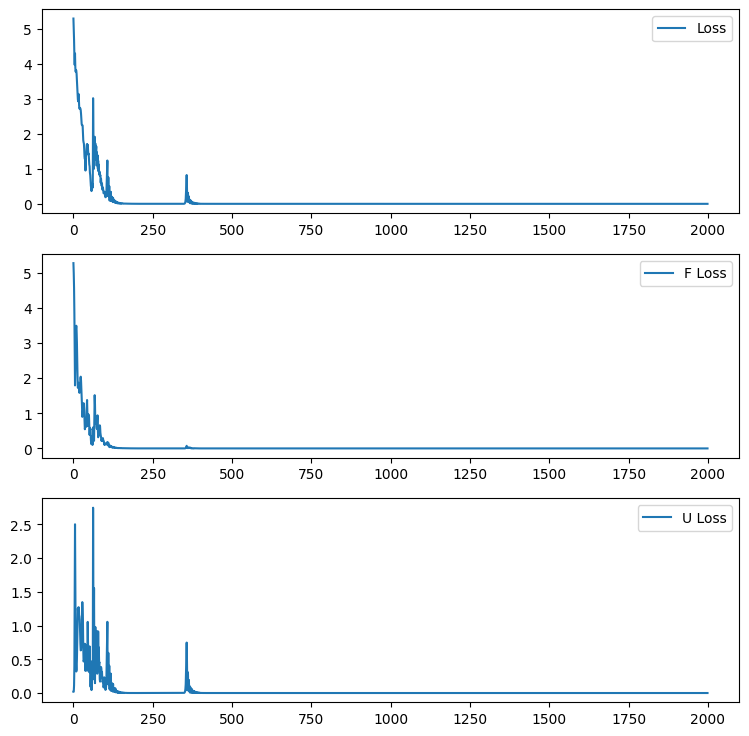

In [5]:
N_f = 10000
#E = 200  # 杨氏模量 GPa
#I = 0.2 * 0.5 ** 3 / 12  # 截面惯性矩  矩形截面
EI= 1
L = 2  # length
F = 2   # point load

x_f_train = np.random.rand(N_f,1) * L
x_f_train = np.vstack((np.array([0]),x_f_train,np.array([L])))
x_f = torch.tensor(x_f_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

# 模型训练
def train(epochs, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.5) # 动态递减学习率
    Losses = []
    f_Losses = []
    u_Losses  =[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss,floss,uloss = Loss(x_f)
        Losses.append(loss.item())
        f_Losses.append(floss.item())
        u_Losses.append(uloss.item())
        if epoch % 100 ==0:
            print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        optimizer.step()
        scheduler.step()
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(311)
    plt.plot(Losses,label='Loss')
    plt.legend()
    ax = fig.add_subplot(312)
    plt.plot(f_Losses,label='F Loss')
    plt.legend()
    ax = fig.add_subplot(313)
    plt.plot(u_Losses,label='U Loss')
    plt.legend()
    plt.show()

def Exact_u(x):
    u = F / (6 * EI) * (3 * L * x * x - x ** 3)
    return u

model = MLP()
train(2000, model)

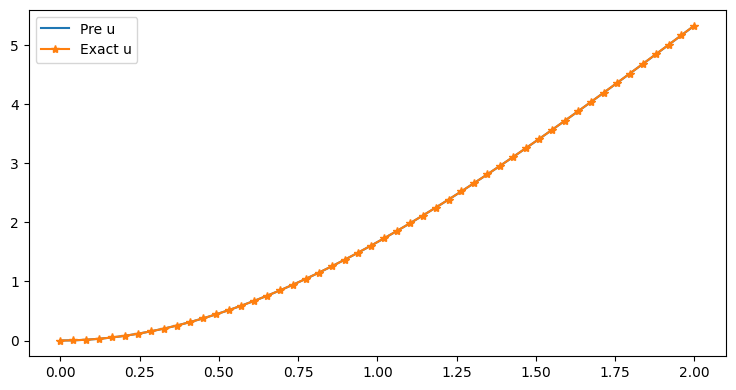

In [9]:
x = torch.linspace(0, L, 50, dtype=torch.float32, requires_grad=True).reshape(-1,1)
ucol = u_function(x)
xnp = x.detach().numpy()
uex = Exact_u(xnp)
unp = ucol.detach().numpy()

fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,unp,label = 'Pre u')
plt.plot(xnp,uex, marker='*',label = 'Exact u')
plt.legend()
plt.show()

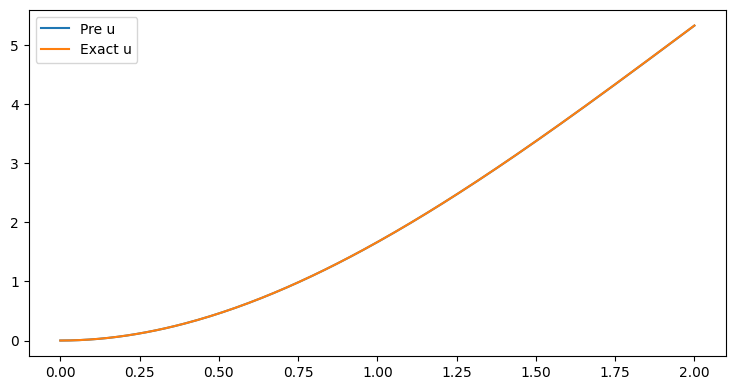

In [7]:
x = torch.linspace(0, L, 200, dtype=torch.float32, requires_grad=True).reshape(-1,1)
ucol = u_function(x)
xnp = x.detach().numpy()
uex = Exact_u(xnp)
unp = ucol.detach().numpy()

fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,unp,label = 'Pre u')
plt.plot(xnp,uex,label = 'Exact u')
plt.legend()
plt.show()

# 简支梁

In [3]:
def u_function(x):
    u = model(x)
    return u

def f_function(x):
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, torch.ones_like(u_xxx), retain_graph=True, create_graph=True)[0]
    
    f = EI * u_xxxx - q
    return u, f, u_x, u_xx, u_xxx, u_xxxx
    
def Loss(x_f):
    u_pre, f_pre, u_x, u_xx, _, _ = f_function(x_f)
    # loss
    
    f_loss = torch.mean(torch.square(f_pre))
    u_loss = torch.square(u_pre[0]) + torch.square(u_pre[-1]) + torch.square(EI * u_xx[0]) + torch.square(EI * u_xx[-1])
    
    ls = u_loss + f_loss
    ls.backward()
    return ls,f_loss,u_loss

In [ ]:
N_f = 10000
EI= 1
L = 10  # length   m
q = 100   # distributed load   N/m

x_f_train = np.random.rand(N_f,1) * L
x_f_train = np.vstack((np.array([0]),x_f_train,np.array([L])))
x_f = torch.tensor(x_f_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

# 模型训练
def train(epochs, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    Losses = []
    f_Losses = []
    u_Losses  =[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss,floss,uloss = Loss(x_f)
        Losses.append(loss.item())
        f_Losses.append(floss.item())
        u_Losses.append(uloss.item())
        if epoch % 100 ==0:
            print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
        optimizer.step()
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(311)
    plt.plot(Losses,label='Loss')
    plt.legend()
    ax = fig.add_subplot(312)
    plt.plot(f_Losses,label='F Loss')
    plt.legend()
    ax = fig.add_subplot(313)
    plt.plot(u_Losses,label='U Loss')
    plt.legend()
    plt.show()

def Exact_u(x):
    u = 25 * x / (3 * EI) * (-x ** 3 / 2 + 10 * x ** 2 - 500)
    return u

model = MLP()
train(2000, model)

[Epoch 1/2000] [loss: 10000.259765625]
[Epoch 101/2000] [loss: 10000.0]


In [ ]:
x = torch.linspace(0, L, 200, dtype=torch.float32, requires_grad=True).reshape(-1,1)
ucol = u_function(x)
xnp = x.detach().numpy()
uex = Exact_u(xnp)
unp = ucol.detach().numpy()

fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
#plt.plot(xnp,unp,label = 'Pre u')
plt.plot(xnp,uex/1000,label = 'Exact u')
plt.legend()
plt.show()